# Logisitic Regressor by Gender- Comparing improvment in College respect to High School times

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegressionCV

In [2]:
df = pd.read_parquet('CLEANED_SWIM_DATA.parquet')
df.head()

,Event,Conf_Rank,Time,Name,School,Standard,Date,Gender,Division,Season,SeasonYear,Time_Adj,Time_Sec,Div_Rank,NCAA_Rank,ID,Power_Tot,Power,Record,Points
0,50 Freestyle SCY Male,-1,21.22,Ben Beldner,Binghamton,NA,2000-01-01,M,HS,00_01,2001,0 days 00:00:21.220000,21.22,-1,-1,394588,22.71,20.52,17.63,573.483330
1,50 Freestyle SCY Male,-1,20.87,Justin Meyn,Binghamton,NA,2000-01-01,M,HS,00_01,2001,0 days 00:00:20.870000,20.87,-1,-1,471360,10.06,20.80,17.63,602.822689
2,50 Freestyle SCY Male,-1,21.31,Joshua Franco,New Jersey Institute of Technology,NA,2000-01-01,M,HS,00_01,2001,0 days 00:00:21.310000,21.31,-1,-1,395308,12.40,22.05,17.63,566.247878
3,50 Freestyle SCY Male,-1,21.05,Gabe Laracuente,UMBC,NA,2000-01-01,M,HS,00_01,2001,0 days 00:00:21.050000,21.05,-1,-1,404642,13.77,23.93,17.63,587.490213
4,50 Freestyle SCY Male,-1,21.70,Ryan Board,Binghamton,NA,2000-01-01,M,HS,00_01,2001,0 days 00:00:21.700000,21.70,-1,-1,422211,18.21,28.82,17.63,536.262879


In [3]:
df['School'] = df['School'].astype('category')
df.loc[:,'isHS'] = df.loc[:,'Division'] == 'HS'

## Male

In [4]:
comparing_male= df[df["Gender"] == "M"].pivot_table(values='Points', index='ID', columns='isHS', aggfunc='max')
comparing_male.head(8)

isHS,False,True
ID,,
2870,558.518217,539.964536
3480,496.925131,656.537006
7361,512.727092,755.965387
55500,580.205021,647.516428
57813,563.014008,560.250951
65699,628.311468,657.547940
88551,437.245173,418.719990
93211,451.504645,633.272970


In [5]:
comparing_male['Difference'] = comparing_male[False] - comparing_male[True]
comparing_male['Difference'] = comparing_male['Difference'].replace([float('inf'), -float('inf')], float('nan'))
comparing_male = comparing_male.dropna(subset=['Difference'])
comparing_male = comparing_male.rename(columns={True: 'Best_HS_Points', False: 'Best_College_Points'})
comparing_male

isHS,Best_College_Points,Best_HS_Points,Difference
ID,,,
2870,558.518217,539.964536,18.553680
3480,496.925131,656.537006,-159.611875
7361,512.727092,755.965387,-243.238295
55500,580.205021,647.516428,-67.311407
57813,563.014008,560.250951,2.763057
...,...,...,...
2937083,503.520181,151.239988,352.280193
2939294,506.676495,426.910590,79.765905
2961793,588.802625,224.215025,364.587600


In [6]:
male = pd.merge(df[['ID', 'School', 'Standard', 'Gender', 'Division', 'Season']], 
                  comparing_male, 
                  on=['ID'], 
                  how='left')
male = male.dropna()
male['Rating'] = pd.cut(male['Difference'], [-1000, 40, 1000], labels = ['bad', 'good'])
male['Rating'].value_counts()

Rating
bad     75969
good    74705
Name: count, dtype: int64

In [8]:
X = male[['Division', 'Season']]
y = male['Rating']

In [9]:
X_n = X.select_dtypes(include = 'number')
X_c = X.select_dtypes(exclude = 'number')
X_n = (X_n-X_n.mean())/X_n.std()
X_c = pd.get_dummies(X_c)
X_preproc = pd.concat([X_n, X_c], axis = 1)
X_preproc

,Division_HS,Division_I,Division_II,Division_III,Season_00_01,Season_19_20,Season_20_21,Season_21_22,Season_22_23,Season_23_24
0,True,False,False,False,True,False,False,False,False,False
1,True,False,False,False,True,False,False,False,False,False
2,True,False,False,False,True,False,False,False,False,False
3,True,False,False,False,True,False,False,False,False,False
4,True,False,False,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...
339206,False,False,False,True,False,False,False,False,True,False
339229,False,False,False,True,False,False,False,False,True,False
339972,False,False,False,True,False,False,False,False,True,False
339973,False,False,False,True,False,False,False,False,True,False


In [10]:
X_preproc = X_preproc.drop(['Division_HS', 'Season_00_01'], axis = 1)

In [11]:
lregCV = LogisticRegressionCV(Cs=100, n_jobs = -1)

In [12]:
lregCV.fit(X_preproc, y)

LogisticRegressionCV(Cs=100, n_jobs=-1)

In [13]:
lregCV.score(X_preproc, y)

0.5169173181836282

In [14]:
coef = lregCV.coef_[0]
coef = pd.Series(coef, index = X_preproc.columns)
coef.sort_values(ascending=False)

Division_I      0.090700
Season_23_24    0.042464
Season_22_23    0.039960
Division_II     0.035093
Season_20_21    0.033022
Division_III    0.031177
Season_19_20    0.023667
Season_21_22    0.017857
dtype: float64

<Axes: >

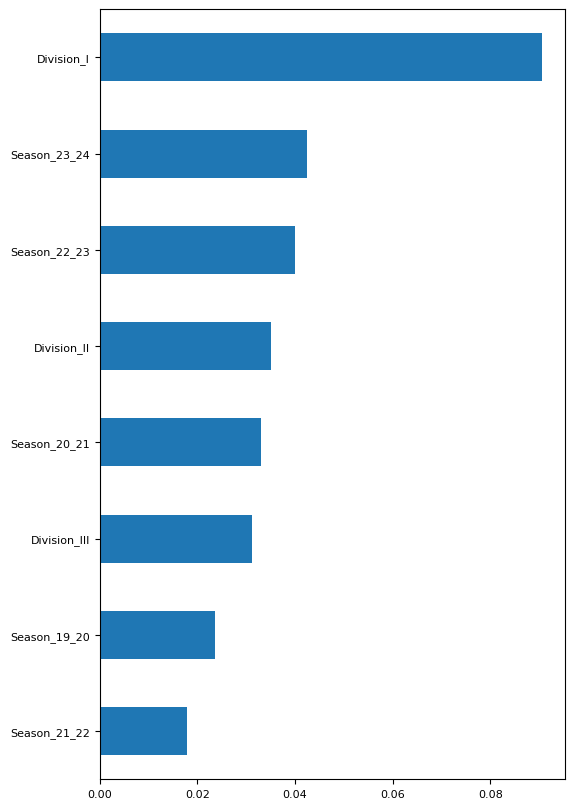

In [15]:
coef.sort_values(ascending=True).plot.barh(fontsize=8, figsize = (6, 10))

## Female

In [16]:
comparing_female= df[df["Gender"] == "F"].pivot_table(values='Points', index='ID', columns='isHS', aggfunc='max')
comparing_female.head(8)

isHS,False,True
ID,,
19185,703.308104,1040.840801
31849,587.552232,598.562896
74887,640.592607,740.663716
75074,708.749168,756.584905
76046,686.261498,486.355765
85496,625.124677,521.204067
86027,319.330589,761.369664
86833,525.516203,470.131466


In [17]:
comparing_female['Difference'] = comparing_female[False] - comparing_female[True]
comparing_female['Difference'] = comparing_female['Difference'].replace([float('inf'), -float('inf')], float('nan'))
comparing_female = comparing_female.dropna(subset=['Difference'])
comparing_female = comparing_female.rename(columns={True: 'Best_HS_Points', False: 'Best_College_Points'})
comparing_female

isHS,Best_College_Points,Best_HS_Points,Difference
ID,,,
19185,703.308104,1040.840801,-337.532697
31849,587.552232,598.562896,-11.010664
74887,640.592607,740.663716,-100.071109
75074,708.749168,756.584905,-47.835737
76046,686.261498,486.355765,199.905733
...,...,...,...
2911878,341.941359,217.213786,124.727572
2914053,672.361402,600.858163,71.503239
3008853,542.245286,265.838311,276.406975


In [18]:
female = pd.merge(df[['ID', 'School', 'Standard', 'Gender', 'Division', 'Season']], 
                  comparing_female, 
                  on=['ID'], 
                  how='left')
female = female.dropna()
female['Rating'] = pd.cut(female['Difference'], [-1000, 16, 1000], labels = ['bad', 'good'])
female['Rating'].value_counts()

Rating
good    103483
bad      99535
Name: count, dtype: int64

In [19]:
X = female[['Division', 'Season']]
y = female['Rating']

In [20]:
X_n = X.select_dtypes(include = 'number')
X_c = X.select_dtypes(exclude = 'number')
X_n = (X_n-X_n.mean())/X_n.std()
X_c = pd.get_dummies(X_c)
X_preproc = pd.concat([X_n, X_c], axis = 1)
X_preproc

,Division_HS,Division_I,Division_II,Division_III,Season_00_01,Season_19_20,Season_20_21,Season_21_22,Season_22_23,Season_23_24
3315,True,False,False,False,True,False,False,False,False,False
3316,True,False,False,False,True,False,False,False,False,False
3317,True,False,False,False,True,False,False,False,False,False
3318,True,False,False,False,True,False,False,False,False,False
3319,True,False,False,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...
354318,False,False,False,True,False,False,False,False,False,True
354319,False,False,False,True,False,False,False,False,False,True
354320,False,False,False,True,False,False,False,False,False,True
354321,False,False,False,True,False,False,False,False,False,True


In [21]:
X_preproc = X_preproc.drop(['Division_HS', 'Season_00_01'], axis = 1)

In [22]:
lregCV = LogisticRegressionCV(Cs=100, n_jobs = -1)

In [23]:
lregCV.fit(X_preproc, y)

LogisticRegressionCV(Cs=100, n_jobs=-1)

In [24]:
lregCV.score(X_preproc, y)

0.5299234550630979

In [25]:
coef = lregCV.coef_[0]
coef = pd.Series(coef, index = X_preproc.columns)
coef.sort_values(ascending=False)

Division_I      0.096148
Division_II     0.073065
Season_22_23    0.032960
Season_20_21    0.027950
Season_23_24    0.027705
Season_19_20    0.023861
Season_21_22    0.014674
Division_III   -0.042063
dtype: float64

<Axes: >

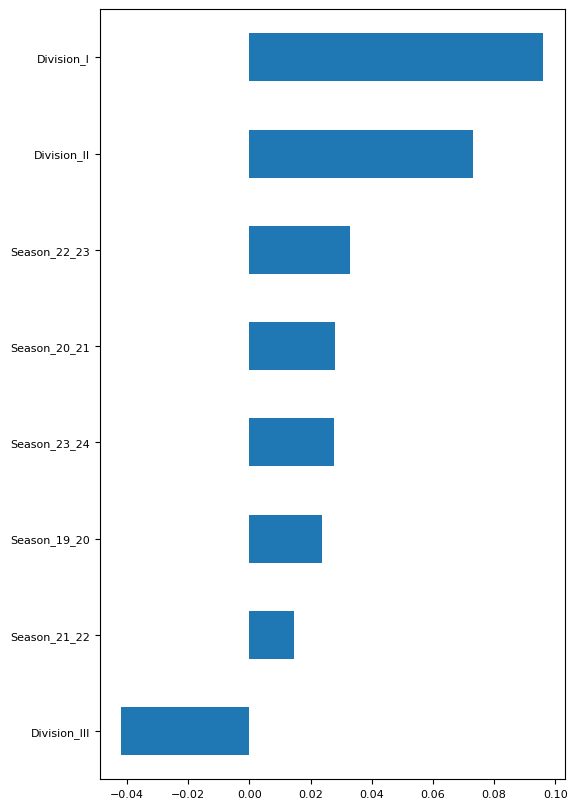

In [26]:
coef.sort_values(ascending=True).plot.barh(fontsize=8, figsize = (6, 10))